In [252]:
import string
import os
import regex as re
import numpy as np
from itertools import combinations, chain
import pickle
from datetime import datetime

from lxml import etree
from operator import itemgetter

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import SnowballStemmer
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk import pos_tag, FreqDist

from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV, SelectFromModel
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

from scipy.sparse import vstack, hstack, coo_matrix
import matplotlib.pyplot as plt

from empath import Empath
from textblob import TextBlob

Pickle up all data:

In [2]:
'''X_times_train = pickle.load(open("./dumps/X_times_train.p", "rb" ))
X_sentence_len_train = pickle.load(open("./dumps/X_sentence_len_train.p", "rb" ))
X_post_cnt_train = pickle.load(open("./dumps/X_post_cnt_train.p", "rb" ))
X_sentiment_train = pickle.load(open("./dumps/X_sentiment_train.p", "rb" ))
X_subjectivity_train = pickle.load(open("./dumps/X_subjectivity_train.p", "rb" ))

X_times_test = pickle.load(open("./dumps/X_times_test.p", "rb" ))
X_sentence_len_test = pickle.load(open("./dumps/X_sentence_len_test.p", "rb" ))
X_post_cnt_test = pickle.load(open("./dumps/X_post_cnt_test.p", "rb" ))
X_sentiment_test = pickle.load(open("./dumps/X_sentiment_test.p", "rb" ))
X_subjectivity_test = pickle.load(open("./dumps/X_subjectivity_test.p", "rb" ))

X_pos_tags_train = pickle.load(open( "X_pos_tags_train.p", "rb" ))
X_pos_tags_test = pickle.load(open( "X_pos_tags_test.p", "rb" ))

X_lexicon_sizes_train = pickle.load(open( "X_lexicon_sizes_train.p", "rb" ))
X_lexicon_sizes_test = pickle.load(open( "X_lexicon_sizes_test.p", "rb" ))'''

'X_times_train = pickle.load(open("./dumps/X_times_train.p", "rb" ))\nX_sentence_len_train = pickle.load(open("./dumps/X_sentence_len_train.p", "rb" ))\nX_post_cnt_train = pickle.load(open("./dumps/X_post_cnt_train.p", "rb" ))\nX_sentiment_train = pickle.load(open("./dumps/X_sentiment_train.p", "rb" ))\nX_subjectivity_train = pickle.load(open("./dumps/X_subjectivity_train.p", "rb" ))\n\nX_times_test = pickle.load(open("./dumps/X_times_test.p", "rb" ))\nX_sentence_len_test = pickle.load(open("./dumps/X_sentence_len_test.p", "rb" ))\nX_post_cnt_test = pickle.load(open("./dumps/X_post_cnt_test.p", "rb" ))\nX_sentiment_test = pickle.load(open("./dumps/X_sentiment_test.p", "rb" ))\nX_subjectivity_test = pickle.load(open("./dumps/X_subjectivity_test.p", "rb" ))\n\nX_pos_tags_train = pickle.load(open( "X_pos_tags_train.p", "rb" ))\nX_pos_tags_test = pickle.load(open( "X_pos_tags_test.p", "rb" ))\n\nX_lexicon_sizes_train = pickle.load(open( "X_lexicon_sizes_train.p", "rb" ))\nX_lexicon_sizes_t

Class for Corpus preprocessing:

In [3]:
sw_diff = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'he', 'him', 'his', 'himself', 
           'she', 'her', 'hers', 'herself', 'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 
           'themselves', 'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
           'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 'totally', 'whole',
           'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}

class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.stopwords.difference_update(sw_diff)
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer(language='english')

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X, method='lem'):
        return [
            list(self.tokenize(doc, method)) for doc in X
        ]   

    def tokenize(self, document, method='lem'):
        if(method == 'lem'):
            # Break the document into sentences
            for sent in sent_tokenize(document):
                # Break the sentence into part of speech tagged tokens
                for token, tag in pos_tag(wordpunct_tokenize(sent)):
                    # Apply preprocessing to the token
                    token = self.process_token(token)
                    if not self.is_valid_token(token):
                        continue
                        
                    # Lemmatize the token and yield
                    lemma = self.lemmatize(token, tag)
                    yield lemma
                    
        elif(method == 'stem'):
            # Break the document into tokens
            for token in wordpunct_tokenize(document):
                # Apply preprocessing to the token
                token = self.process_token(token)
                if not self.is_valid_token(token):
                    continue
                
                stem = self.stem(token)
                yield stem
        else:
            raise ValueError('Unknown method type.')

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
    
    def stem(self, token):
        return self.stemmer.stem(token)
    
    def process_token(self, token):
        token = token.lower() if self.lower else token
        token = token.strip() if self.strip else tcharoken
        token = token.strip('_') if self.strip else token
        token = token.strip('*') if self.strip else token
        return token
    
    def is_valid_token(self, token):
        # If stopword, token is invalid
        if token in self.stopwords:
            return False

        # If punctuation, token is invalid
        if all(char in self.punct for char in token):
            return False
        
        return True

This part of code loads data corpus from multiple files into lists X (texts) and y(labels) with one entry per user:

In [4]:
def read_entries(X, y, path_list, label_dict=None, default_label=0):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
    
    IMAGE_STR = 'data:image'
    
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_id = root[0].text
        
            user_text = ''
            for post in root.findall('.//TITLE') + root.findall('.//TEXT'):
                post = post.text.strip().strip()
                if post != '':
                    if IMAGE_STR in post:
                        continue
                    post = re.sub(r"http\S+", " ", post)
                    post = re.sub(r"\d+", " ", post)
                    post = re.sub(u"\xa0", " ", post)
                    post = re.sub(u"\\p{P}+", " ", post)
                    user_text += ' ' + post.lower()
            
            X.append(user_text)
            label = int(label_dict[user_id]) if label_dict else default_label
            y.append(label)

Utility methods for extracting features:

In [5]:
def get_avg_sentence_length(sentences):
    sum = 0
    for sentence in sentences:
        sentence = sentence.replace(' ', '')
        sum += len(sentence)
    return sum / len(sentences) if sentences else 0

In [6]:
def get_sentiment_and_subjectivity(sentences):
    sum_sentiment = 0
    sum_subjectivity = 0
    if len(sentences) > 0:
        for sentence in sentences:
            tb = TextBlob(sentence)
            sum_sentiment += tb.sentiment.polarity
            sum_subjectivity += tb.sentiment.subjectivity
        sum_sentiment = sum_sentiment / float(len(sentences))
        sum_subjectivity = sum_subjectivity / float(len(sentences))
        return (sum_sentiment, sum_subjectivity)
    else:
        return (0.0, 0.0)
        

In [7]:
def read_features(X_times, X_sentence_lengths, X_post_cnt, X_sentiment,
                  X_subjectivity, X_post_lengths, X_post_freq, path_list):
    entry_lists = []
    for path in path_list:
        entry_lists.append(os.scandir(path))
        
    IMAGE_STR = 'data:image'
    datetime_pattern = '%Y-%m-%d %H:%M:%S'
    date_end = None
    date_start = None
    
    for list_of_entries in entry_lists:
        for entry in list_of_entries:
            root = etree.parse(entry.path).getroot()
            user_id = root[0].text
            
            sentences = []
            post_lengths = []
            post_cnt = 0
            for post in root.findall('.//TEXT'):
                post_cnt += 1
                post = post.text.strip()
                if post != '':
                    sentences.extend(sent_tokenize(post))
                    post_lengths.append(len(post))
                else:
                    post_lengths.append(0)
            
            avg_sentiment, avg_subjectivity = get_sentiment_and_subjectivity(sentences)
            avg_sentence_length = get_avg_sentence_length(sentences)
            avg_post_length = np.mean(post_lengths)
            
            sum_hours = 0
            for date in root.findall('.//DATE'):
                date = date.text.strip()
                if date != '':                    
                    if not date_end:
                        date_end = datetime.strptime(date, datetime_pattern)
                    date_start = datetime.strptime(date, datetime_pattern)
                    
                    m = re.match(r'\d{4}-\d{2}-\d{2} (\d{2}).*', date)
                    hour = int(m.group(1))
                    sum_hours += hour
            
            post_span_minutes = (date_end - date_start).total_seconds()/60
            post_freq = post_span_minutes / post_cnt
            
            time = [0] * 8
            avg_hour = sum_hours / post_cnt
            index = int(avg_hour // 3)
            time[index] = 1
            
            X_post_cnt.append([post_cnt])
            X_sentence_lengths.append([avg_sentence_length])
            X_times.append(time)
            X_sentiment.append([avg_sentiment])
            X_subjectivity.append([avg_subjectivity])
            X_post_lengths.append([avg_post_length])
            X_post_freq.append([post_freq])

Reading input files:

In [8]:
cwd = os.getcwd()
TRAIN_PATH = os.path.join(cwd, "reddit-training-ready-to-share")
TEST_PATH = os.path.join(cwd, "reddit-test-data-ready-to-share")

TRAIN_POSITIVE_PATH = os.path.join(TRAIN_PATH, "positive_examples_anonymous")
TRAIN_NEGATIVE_PATH = os.path.join(TRAIN_PATH, "negative_examples_anonymous")

TEST_POSITIVE_PATH = os.path.join(TEST_PATH, "positive_examples_anonymous")
TEST_NEGATIVE_PATH = os.path.join(TEST_PATH, "negative_examples_anonymous")

TRAIN_LABELS_PATH = os.path.join(cwd, 'risk_golden_truth.txt')

IMAGE_STR = 'data:image'

train_labels_file = open(TRAIN_LABELS_PATH, 'r')
train_label_dict = {}
for line in train_labels_file:
    xml_file, label = line.split(' ')
    train_label_dict[xml_file] = label
train_labels_file.close()

In [9]:
X_train_raw = []
y_train = []
X_test_raw = []
y_test = []

train_entry_path_list = [TRAIN_POSITIVE_PATH, TRAIN_NEGATIVE_PATH]
test_pos_entry_path_list = [TEST_POSITIVE_PATH]
test_neg_entry_path_list = [TEST_NEGATIVE_PATH]

read_entries(X=X_train_raw, y=y_train, path_list=train_entry_path_list, label_dict=train_label_dict)
read_entries(X=X_test_raw, y=y_test, path_list=test_pos_entry_path_list, default_label=1)
read_entries(X=X_test_raw, y=y_test, path_list=test_neg_entry_path_list, default_label=0)

In [10]:
def get_pronoun_and_absolutizm_features(X_raw):
    
    fp_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
    
    tp_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                   'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves'}
    
    absolutisms = {'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
                   'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                   'totally', 'whole', 'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}


    fp_freq = []
    tp_freq = []
    absolutisms_freq = []
    
    for entry in X_raw:
        sum_fp = 0
        sum_tp = 0
        sum_abs = 0
        tokens = word_tokenize(entry)
        for word in tokens:
            if word in fp_pronouns:
                sum_fp += 1
            elif word in tp_pronouns:
                sum_tp += 1
            elif word in absolutisms:
                sum_abs += 1
        sum_fp = sum_fp / float(len(tokens))
        sum_tp = sum_tp / float(len(tokens))
        sum_abs = sum_abs / float(len(tokens))
        fp_freq.append([sum_fp])
        tp_freq.append([sum_tp])
        absolutisms_freq.append([sum_abs])
    
    return (fp_freq, tp_freq, absolutisms_freq)        

In [11]:
def get_pronoun_and_absolutizm_features2(X_raw):
    
    fp_pronouns = {'i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours', 'ourselves'}
    
    tp_pronouns = {'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
                   'you', 'your', 'yours', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves'}
    
    absolutisms = {'absolutely', 'all', 'always', 'complete', 'completely', 'constant', 'constantly','definitely', 
                   'entire', 'ever', 'every', 'everyone', 'everything', 'full', 'must', 'never', 'nothing', 
                   'totally', 'whole', 'just', 'only', 'noone', 'none', 'no', 'nobody', 'each', 'everybody'}


    fp_freq = []
    tp_freq = []
    absolutisms_freq = []
    
    for entry in X_raw:
        sum_fp = 0
        sum_tp = 0
        sum_abs = 0
        tokens = word_tokenize(entry)
        tokens = [word for word in tokens if len(word) > 1]
        tokens = [word for word in tokens if not word.isnumeric()]
        fdist = FreqDist(tokens)
        w, f = fdist.most_common(1)[0]
        for word in tokens:
            if word in fp_pronouns:
                sum_fp += 1
            elif word in tp_pronouns:
                sum_tp += 1
            elif word in absolutisms:
                sum_abs += 1
        sum_fp = sum_fp / float(f)
        sum_tp = sum_tp / float(f)
        sum_abs = sum_abs / float(f)
        fp_freq.append([sum_fp])
        tp_freq.append([sum_tp])
        absolutisms_freq.append([sum_abs])
    
    return (fp_freq, tp_freq, absolutisms_freq)        

Extracting features:

In [12]:
X_times_train = []
X_times_test = []

X_sentence_len_train = []
X_sentence_len_test = []

X_post_cnt_train = []
X_post_cnt_test = []

X_sentiment_train = []
X_sentiment_test = []

X_subjectivity_train = []
X_subjectivity_test = []

X_post_lengths_train = []
X_post_lengths_test = []

X_post_freq_train = []
X_post_freq_test = []

read_features(X_times=X_times_train, X_sentence_lengths=X_sentence_len_train, X_post_cnt=X_post_cnt_train,
              X_sentiment=X_sentiment_train, X_subjectivity=X_subjectivity_train, X_post_lengths=X_post_lengths_train,
              X_post_freq=X_post_freq_train, path_list=train_entry_path_list)
read_features(X_times=X_times_test, X_sentence_lengths=X_sentence_len_test, X_post_cnt=X_post_cnt_test,
              X_sentiment=X_sentiment_test, X_subjectivity=X_subjectivity_test, X_post_lengths=X_post_lengths_test,
              X_post_freq=X_post_freq_test, path_list=test_pos_entry_path_list)
read_features(X_times=X_times_test, X_sentence_lengths=X_sentence_len_test, X_post_cnt=X_post_cnt_test,
              X_sentiment=X_sentiment_test, X_subjectivity=X_subjectivity_test, X_post_lengths=X_post_lengths_test,
              X_post_freq=X_post_freq_test, path_list=test_neg_entry_path_list)

In [13]:
X_fp_pronouns_train, X_tp_pronouns_train, X_absolutisms_train = get_pronoun_and_absolutizm_features2(X_train_raw)
X_fp_pronouns_test, X_tp_pronouns_test, X_absolutisms_test = get_pronoun_and_absolutizm_features2(X_test_raw)

In [14]:
def get_semantic_features(X):
    lexicon = Empath()
    
    relevant_lexical_categories = ['negative_emotion', 'positive_emotion', 'communication',
                                    'violence', 'business', 'nervousness', 'body', 'pain',
                                    'internet', 'work', 'shame', 'poor'
                              ]
    
    relevant_lexical_categories2 = ['negative_emotion', 'positive_emotion',
                                   'nervousness', 'love', 'shame', 'pain'
                              ]
    
    relevant_lexical_categories3 = ['friends', 'positive_emotion', 'negative_emotion', 
                                   'nervousness', 'love', 'shame', 'pain', 'optimism', 'sadness',
                                    'speaking'
                              ]
    
    feature_mat = []
    for text in X:
        d = lexicon.analyze(text, categories=relevant_lexical_categories3, normalize=True)
        feature_mat.append([d[key] for key in sorted(d.keys(), reverse=False)])
    return feature_mat

In [15]:
X_sem_feat_train = get_semantic_features(X_train_raw)
X_sem_feat_test = get_semantic_features(X_test_raw)

In [16]:
pickle.dump(X_times_train, open("./dumps/X_times_train.p", "wb" ))
pickle.dump(X_sentence_len_train, open("./dumps/X_sentence_len_train.p", "wb" ))
pickle.dump(X_post_cnt_train, open("./dumps/X_post_cnt_train.p", "wb" ))
pickle.dump(X_sentiment_train, open("./dumps/X_sentiment_train.p", "wb" ))
pickle.dump(X_subjectivity_train, open("./dumps/X_subjectivity_train.p", "wb" ))
pickle.dump(X_post_lengths_train, open("./dumps/X_post_lengths_train.p", "wb" ))
pickle.dump(X_post_freq_train, open("./dumps/X_post_freq_train.p", "wb" ))
pickle.dump(X_fp_pronouns_train, open("./dumps/X_fp_pronouns_train.p", "wb" ))
pickle.dump(X_tp_pronouns_train, open("./dumps/X_tp_pronouns_train.p", "wb" ))
pickle.dump(X_absolutisms_train, open("./dumps/X_absolutisms_train.p", "wb" ))

pickle.dump(X_times_test, open("./dumps/X_times_test.p", "wb" ))
pickle.dump(X_sentence_len_test, open("./dumps/X_sentence_len_test.p", "wb" ))
pickle.dump(X_post_cnt_test, open("./dumps/X_post_cnt_test.p", "wb" ))
pickle.dump(X_sentiment_test, open("./dumps/X_sentiment_test.p", "wb" ))
pickle.dump(X_subjectivity_test, open("./dumps/X_subjectivity_test.p", "wb" ))
pickle.dump(X_post_lengths_test, open("./dumps/X_post_lengths_test.p", "wb" ))
pickle.dump(X_post_freq_test, open("./dumps/X_post_freq_test.p", "wb" ))
pickle.dump(X_fp_pronouns_test, open("./dumps/X_fp_pronouns_test.p", "wb" ))
pickle.dump(X_tp_pronouns_test, open("./dumps/X_tp_pronouns_test.p", "wb" ))
pickle.dump(X_absolutisms_test, open("./dumps/X_absolutisms_test.p", "wb" ))

pickle.dump(X_sem_feat_train, open("./dumps/X_sem_feat_train.p", "wb" ))
pickle.dump(X_sem_feat_test, open("./dumps/X_sem_feat_test.p", "wb" ))

We use X list as input to NLTKPreprocessor class which outputs list of preprocessed, tokenized texts:

In [17]:
preprocessor = NLTKPreprocessor()
preprocess_method = 'stem'
X_train_prep = preprocessor.transform(X_train_raw, method=preprocess_method)
X_test_prep = preprocessor.transform(X_test_raw, method=preprocess_method)

In [18]:
def get_pos_tags(X):
    pos_tag_mat = []
    for tokens in X:
       # tag_dict = { 'CC': 0, 'DT': 0, 'IN': 0, 'JJ': 0, 'JJR': 0, 'JJS': 0,
       #             'NN': 0, 'NNP':0, 'NNS': 0, 'PRP': 0, 'PRP$': 0, 'RB': 0,
       #             'RBR': 0, 'RBS': 0, 'RP': 0, 'VB': 0, 'VBD': 0, 'VBG': 0,
        #            'VBN': 0, 'VBP': 0, 'VBZ': 0}
        tag_dict = {'JJ': 0, 'JJS': 0,
                    'NN': 0, 'NNS': 0, 'PRP': 0, 'PRP$': 0,
                    'RBS': 0, 'VB': 0, 'VBD': 0,
                    'VBN': 0, 'VBP': 0, 'VBZ': 0}
        
        text_len = len(tokens)
        tags = pos_tag(tokens)
        
        for word, tag in tags:
            if tag in tag_dict.keys():
                tag_dict[tag] += 1/text_len
        
        tag_freq = [tag_dict[key] for key in sorted(tag_dict.keys(), reverse=False)]
        pos_tag_mat.append(tag_freq)
    
    return pos_tag_mat

In [19]:
X_pos_tags_train = get_pos_tags(X_train_prep)
X_pos_tags_test = get_pos_tags(X_test_prep)

In [20]:
pickle.dump(X_pos_tags_train, open("./dumps/X_pos_tags_train.p", "wb" ))
pickle.dump(X_pos_tags_test, open("./dumps/X_pos_tags_test.p", "wb" ))

In [21]:
def get_lexicon_sizes(X):
    unique_cnt_mat = []
    for tokens in X:
        unique_cnt_mat.append([len(set(tokens))])
    
    return unique_cnt_mat

In [22]:
X_lexicon_sizes_train = get_lexicon_sizes(X_train_prep)
X_lexicon_sizes_test = get_lexicon_sizes(X_test_prep)

In [23]:
pickle.dump(X_lexicon_sizes_train, open("./dumps/X_lexicon_sizes_train.p", "wb" ))
pickle.dump(X_lexicon_sizes_test, open("./dumps/X_lexicon_sizes_test.p", "wb" ))

We use tf-idf vectorizer for vector representation of the documents:

In [24]:
def identity(arg):
    """
    Simple identity function works as a passthrough.
    """
    return arg

In [25]:
vect = TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, ngram_range=(1, 1), min_df=30)
X_train = vect.fit_transform(X_train_prep, y_train)
X_test = vect.transform(X_test_prep)

In [26]:
#print(vect.get_feature_names())
#print(X_train.getnnz())

Normalizing and adding features:

In [27]:
max_abs_scaler = StandardScaler()
#max_abs_scaler = MaxAbsScaler()
#max_abs_scaler = MinMaxScaler()
X_sentence_len_train_scaled = max_abs_scaler.fit_transform(X_sentence_len_train)
X_sentence_len_test_scaled = max_abs_scaler.transform(X_sentence_len_test)

X_sem_feat_train_scaled = max_abs_scaler.fit_transform(X_sem_feat_train)
X_sem_feat_test_scaled = max_abs_scaler.transform(X_sem_feat_test)

X_post_cnt_train_scaled = max_abs_scaler.fit_transform(X_post_cnt_train)
X_post_cnt_test_scaled = max_abs_scaler.transform(X_post_cnt_test)

X_sentiment_train_scaled = max_abs_scaler.fit_transform(X_sentiment_train)
X_sentiment_test_scaled = max_abs_scaler.transform(X_sentiment_test)

X_subjectivity_train_scaled = max_abs_scaler.fit_transform(X_subjectivity_train)
X_subjectivity_test_scaled = max_abs_scaler.transform(X_subjectivity_test)

X_fp_pronouns_train_scaled = max_abs_scaler.fit_transform(X_fp_pronouns_train)
X_fp_pronouns_test_scaled = max_abs_scaler.transform(X_fp_pronouns_test)

X_tp_pronouns_train_scaled = max_abs_scaler.fit_transform(X_tp_pronouns_train)
X_tp_pronouns_test_scaled = max_abs_scaler.transform(X_tp_pronouns_test)

X_absolutisms_train_scaled = max_abs_scaler.fit_transform(X_absolutisms_train)
X_absolutisms_test_scaled = max_abs_scaler.transform(X_absolutisms_test)

X_pos_tags_train_scaled = max_abs_scaler.fit_transform(X_pos_tags_train)
X_pos_tags_test_scaled = max_abs_scaler.transform(X_pos_tags_test)

X_lexicon_sizes_train_scaled = max_abs_scaler.fit_transform(X_lexicon_sizes_train)
X_lexicon_sizes_test_scaled = max_abs_scaler.transform(X_lexicon_sizes_test)

X_post_lengths_train_scaled = max_abs_scaler.fit_transform(X_post_lengths_train)
X_post_lengths_test_scaled = max_abs_scaler.transform(X_post_lengths_test)

X_post_freq_train_scaled = max_abs_scaler.fit_transform(X_post_freq_train)
X_post_freq_test_scaled = max_abs_scaler.transform(X_post_freq_test)

Building and evaluating models:

In [28]:
#helper function to find allsubsets of a set (needed to find all subsets of set of new feature for CV)
allsubsets = lambda n: list(chain(*[combinations(range(n), ni) for ni in range(n+1)]))

# r - return only subsets of r size (reduction of search space) + empty set; if None, return all subsets
def get_subsets(n, r=None):
    if r==None:
        return allsubsets(n)
    else:
        combs = list(combinations(range(n), r))
        return combs

In [29]:
def majority_weight(w):
    return 1.0 / (1.0 + w)

def minority_weight(w):
    return w / (1.0 + w)

In [30]:
print(len(get_subsets(12, 10)))

66


In [104]:
#Function for k-fold cross-validation of a model
#Performs grid search on C parameter, subsets of new features and k-best token features by chi2 stat
#For model_name parameter use 'SVM' - SVM or 'LR' - LogisticRegression

#EXAMPLE: see example below baseline for CV of SVM model
def cross_validate_model(model_name, X_train, y_train, C_list, k_list, new_features, k_folds, subset_size=None,
                        regularization='l2'):
    feature_subsets = get_subsets(len(new_features), subset_size)
    best_C = 0
    best_k = 0
    best_feature_set = {}
    best_score = -1
    scorer = make_scorer(f1_score, average='macro', labels=[1])
    
    for k_features in k_list:
        
        chi2_selector = SelectKBest(chi2, k=k_features)
        X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
        
        for c in C_list:
            
            if model_name == 'SVM':
                model = LinearSVC(class_weight='balanced', C=c, penalty=regularization) 
            elif model_name == 'LR':
                model = LogisticRegression(class_weight='balanced', C=c, penalty=regularization)
            
            for subset in feature_subsets:
                X_new = X_kbest_train
                for i in subset:
                    X_new = hstack([X_new, new_features[i]])
                scores = cross_val_score(model, X_new, y_train, cv=k_folds, scoring=scorer)
                mean = scores.mean()
                if mean > best_score:
                    best_score = mean
                    best_C = c
                    best_k = k_features
                    best_feature_set = subset
         
    return (best_score, best_k, best_C, best_feature_set)

In [110]:
def feature_cross_validate_model(model_name, X_train, y_train, C_list, k_list, k_folds, feature, regularization='l2'):
    best_C = 0
    best_score = -1
    scorer = make_scorer(f1_score, average='macro', labels=[1])    
    best_k = 0
    
    for k_features in k_list:
        chi2_selector = SelectKBest(chi2, k=k_features)
        X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
        X_kbest_train = hstack([X_kbest_train, feature])

        for c in C_list:
                if model_name == 'SVM':
                    model = LinearSVC(class_weight='balanced', C=c, penalty=regularization) 
                elif model_name == 'LR':
                    model = LogisticRegression(class_weight='balanced', C=c, penalty=regularization)

                scores = cross_val_score(model, X_kbest_train, y_train, cv=k_folds, scoring=scorer)
                mean = scores.mean()
                if mean > best_score:
                        best_score = mean
                        best_C = c
                        best_k = k_features

    return (best_score, best_C, best_k)

In [111]:
def cross_validate_baseline(model_name, X_train, y_train, C_list, k_list, k_folds, regularization='l2'):
    best_C = 0
    best_score = -1
    best_k = 0
    scorer = make_scorer(f1_score, average='macro', labels=[1])
    
    for k_features in k_list:
        
        chi2_selector = SelectKBest(chi2, k=k_features)
        X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
        
        for c in C_list:
            if model_name == 'SVM':
                model = LinearSVC(class_weight="balanced", C=c, penalty=regularization) 
            elif model_name == 'LR':
                model = LogisticRegression(class_weight="balanced", C=c, penalty=regularization)

            scores = cross_val_score(model, X_kbest_train, y_train, cv=k_folds, scoring=scorer)
            mean = scores.mean()
            if mean > best_score:
                    best_score = mean
                    best_C = c
                    best_k = k_features
         
    return (best_score, best_k, best_C)

In [183]:
def cross_validate_new_features(model_name, X_train, y_train, C_list, k_folds, regularization='l2'):
    best_C = 0
    best_score = -1
    scorer = make_scorer(f1_score, average='macro', labels=[1])
        
    for c in C_list:
        if model_name == 'SVM':
            model = LinearSVC(class_weight="balanced", C=c, penalty=regularization) 
        elif model_name == 'LR':
            model = LogisticRegression(class_weight="balanced", C=c, penalty=regularization)

        scores = cross_val_score(model, X_train, y_train, cv=k_folds, scoring=scorer)
        mean = scores.mean()
        if mean > best_score:
                best_score = mean
                best_C = c
         
    return (best_score, best_C)

In [117]:
#CV for Logistic Regression Baseline
C_range = 2. ** np.arange(-1, 9)
k_range = [1000, 1500, 'all']

best_score, best_k, best_C = cross_validate_baseline('LR', X_train, y_train, C_range, k_range, 5, 'l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))

Best score: 0.6671353496353496
Best C: 16.0
Best k: 1500


In [119]:
#CV for SVM baseline
C_range = 2. ** np.arange(-1, 9)
k_range = [1000, 1500, 'all']

best_score, best_k, best_C = cross_validate_baseline('SVM', X_train, y_train, C_range, k_range, 5)

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))

Best score: 0.6879221432162609
Best C: 8.0
Best k: 1500


In [118]:
print("Building for evaluation: BASELINE Logistic Regression L1")

model = LogisticRegression(class_weight='balanced', penalty='l1', C=16.0)

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

model.fit(X_kbest_train, y_train)

print("Classification Report:\n")
y_pred = model.predict(X_kbest_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: BASELINE Logistic Regression L1
Classification Report:

             precision    recall  f1-score   support

          0     0.9517    0.8949    0.9224       352
          1     0.5067    0.7037    0.5891        54

avg / total     0.8925    0.8695    0.8781       406



In [120]:
print("Building for evaluation: BASELINE SVM")

model = LinearSVC(class_weight='balanced', C=8.0)

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

model.fit(X_kbest_train, y_train)

print("Classification Report:\n")
y_pred = model.predict(X_kbest_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: BASELINE SVM
Classification Report:

             precision    recall  f1-score   support

          0     0.9547    0.8977    0.9253       352
          1     0.5200    0.7222    0.6047        54

avg / total     0.8969    0.8744    0.8827       406



In [121]:
print("Voting classifier for baselines (SVM + LR)")

model1 = LogisticRegression(class_weight='balanced', C=16.0, penalty='l1')
model2 = SVC(class_weight='balanced', kernel='linear', C=8.0, probability=True)
model = VotingClassifier(estimators=[('lr', model1), ('svm', model2)], voting='soft')

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)
model.fit(X_kbest_train, y_train)

print("Classification Report:\n")
y_pred = model.predict(X_kbest_test)
print(classification_report(y_test, y_pred, digits=4))

Voting classifier for baselines (SVM + LR)
Classification Report:

             precision    recall  f1-score   support

          0     0.9452    0.9318    0.9385       352
          1     0.5932    0.6481    0.6195        54

avg / total     0.8984    0.8941    0.8961       406



/home/andrija/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [157]:
#Cross validation of SVM
C_range = 2. ** np.arange(-1, 9)
#k_range = np.arange(10, 3000, 300)
#C_range = [0.01, 0.1, 1, 10, 100]
k_range = [1500]
new_features = [X_times_train, X_sentence_len_train_scaled, X_sem_feat_train_scaled,
                      X_post_cnt_train_scaled, X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_pos_tags_train_scaled, X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

#best_feature_set vraća kao tuple indexa u listi new_features (gore)
best_score, best_k, best_C, best_feature_set = cross_validate_model('SVM', X_train, y_train, C_range,
                                                                   k_range, new_features, 4, 10)

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))
print("Best new feature subset: " + str(best_feature_set))

Best score: 0.7338615522783135
Best C: 32.0
Best k: 1200
Best new feature subset: (0, 1, 2, 3, 4, 5, 6, 7, 9, 10)


In [321]:
final_training = [X_times_train, X_sentence_len_train_scaled, X_sem_feat_train_scaled,
                      X_post_cnt_train_scaled, X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_pos_tags_train_scaled, X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

final_testing = [X_times_test, X_sentence_len_test_scaled, X_sem_feat_test_scaled,
                      X_post_cnt_test_scaled, X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_pos_tags_test_scaled, X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled, 
                      X_post_freq_test_scaled]

reduced_training = [X_sentence_len_train_scaled, X_sem_feat_train_scaled[:,:3],
                      X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

reduced_testing = [X_sentence_len_test_scaled, X_sem_feat_test_scaled[:,:3],
                    X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled, 
                      X_post_freq_test_scaled]

In [184]:
#malo igranje
C_range = 2. ** np.arange(-1, 9)
k_range = [1000, 1500, 'all']

best_score, best_C = cross_validate_new_features('LR', np.hstack(final_training), y_train, C_range, 5, regularization='l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))

Best score: 0.6091847684072148
Best C: 0.5


Optimal number of features : 10
[ True False  True  True False  True  True  True  True  True  True  True]


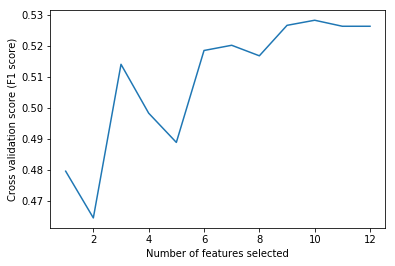

In [344]:
estimator = LogisticRegression(class_weight='balanced', C=1.0, penalty='l1')
selector = RFECV(estimator, step=1, cv=StratifiedKFold(5), scoring=make_scorer(f1_score, average='macro', labels=[1]))
X_train_new = selector.fit_transform(np.hstack(reduced_training), y_train)
X_test_new = selector.transform(np.hstack(reduced_testing))
print("Optimal number of features : %d" % selector.n_features_)
print(selector.support_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (F1 score)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

Feature ranking:
1. feature 6 (0.140747)
2. feature 2 (0.096533)
3. feature 10 (0.092257)
4. feature 3 (0.091629)
5. feature 8 (0.089495)
6. feature 11 (0.081412)
7. feature 7 (0.075232)
8. feature 5 (0.073490)
9. feature 1 (0.072865)
10. feature 9 (0.065174)
11. feature 0 (0.063258)
12. feature 4 (0.057908)
(486, 5)


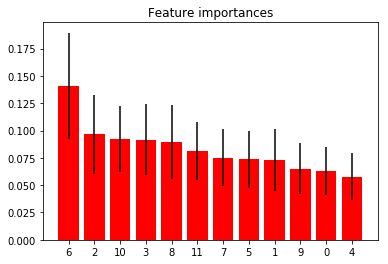

In [396]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=500, random_state=0)
X = np.hstack(reduced_training)
forest.fit(X, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
selector = SelectFromModel(forest, prefit=True)
X_train_new = selector.transform(np.hstack(reduced_training))
X_test_new = selector.transform(np.hstack(reduced_testing))
print(X_train_new.shape)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [399]:
#Individual feature CV
#C_range = 2. ** np.arange(-1, 8)
C_range = [1, 2, 4, 8, 9, 10, 12, 14, 16, 18, 20, 21, 22, 23, 32, 64]
k_range = [1500]
best_score, best_C, best_k = feature_cross_validate_model('LR', X_train, y_train, C_range, k_range, 5, 
                                                  X_train_new, regularization='l1')
print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))

Best score: 0.6635894660894661
Best C: 22
Best k: 1500


In [400]:
print("Building for evaluation: Logistic Regression classifier")

model = LogisticRegression(class_weight='balanced', C=22.0, penalty='l1')

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

X_final_train = hstack([X_kbest_train, X_train_new])  
X_final_test = hstack([X_kbest_test, X_test_new])

#X_final_train = np.hstack(final_training)
#X_final_test = np.hstack(final_testing)

model.fit(X_final_train, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model.predict(X_final_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: Logistic Regression classifier
Evaluation model fit
Classification Report:

             precision    recall  f1-score   support

          0     0.9520    0.9006    0.9255       352
          1     0.5205    0.7037    0.5984        54

avg / total     0.8946    0.8744    0.8820       406



In [398]:
print("Building for evaluation: SVM classifier")

model = LinearSVC(class_weight='balanced', C=8.0)

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

X_final_train = hstack([X_kbest_train, X_train_new])  
X_final_test = hstack([X_kbest_test, X_test_new])
#X_final_train = np.hstack(final_training)
#X_final_test = np.hstack(final_testing)

model.fit(X_final_train, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model.predict(X_final_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: SVM classifier
Evaluation model fit
Classification Report:

             precision    recall  f1-score   support

          0     0.9548    0.9006    0.9269       352
          1     0.5270    0.7222    0.6094        54

avg / total     0.8979    0.8768    0.8847       406



In [144]:
#Cross validation of Logistic Regression BEST FEATURES
C_range = 2. ** np.arange(-1, 9)
k_range = [1500, 'all']
new_features = [final_training[2][:,:3], final_training[5], final_training[7]]

#best_feature_set vraća kao tuple indexa u listi new_features (gore)
best_score, best_k, best_C, best_feature_set_lr = cross_validate_model('LR', X_train, y_train, C_range,
                                                                   k_range, new_features, 5, 3, 'l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))
print("Best new feature subset: " + str(best_feature_set_lr))

Best score: 0.6428862411297744
Best C: 32.0
Best k: 1500
Best new feature subset: (0, 1, 2)


In [172]:
#Crossvalidation for Logistic Regression - INDEPENDENT of SVM
C_range = 2. ** np.arange(-1, 9)
#k_range = np.arange(10, 3000, 300)
#C_range = [0.01, 0.1, 1, 10, 100]
k_range = [1200, 1500, 1700]
new_features_lr = [X_times_train, X_sem_feat_train_scaled,
                      X_post_cnt_train_scaled, X_sentiment_train_scaled, X_subjectivity_train_scaled, 
                      X_fp_pronouns_train_scaled, X_tp_pronouns_train_scaled, X_absolutisms_train_scaled, 
                      X_pos_tags_train_scaled, X_lexicon_sizes_train_scaled, X_post_lengths_train_scaled, 
                      X_post_freq_train_scaled]

#best_feature_set vraća kao tuple indexa u listi new_features (gore)
best_score, best_k, best_C, best_feature_set_lr = cross_validate_model('LR', X_train, y_train, C_range,
                                                                   k_range, new_features_lr, 4, 10, 'l1')

print("Best score: " + str(best_score))
print("Best C: " + str(best_C))
print("Best k: " + str(best_k))
print("Best new feature subset: " + str(best_feature_set_lr))

Best score: 0.6747660427807486
Best C: 4.0
Best k: 1500
Best new feature subset: (0, 1, 2, 3, 5, 6, 7, 8, 9, 10)


In [174]:
new_features_test_lr = [X_times_test, X_sem_feat_test_scaled,
                      X_post_cnt_test_scaled, X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled]

new_features_test_lr_2 = [X_times_test, X_sem_feat_test_scaled,
                      X_post_cnt_test_scaled, X_sentiment_test_scaled, X_subjectivity_test_scaled, 
                      X_fp_pronouns_test_scaled, X_tp_pronouns_test_scaled, X_absolutisms_test_scaled, 
                      X_pos_tags_test_scaled, X_lexicon_sizes_test_scaled, X_post_lengths_test_scaled, 
                      X_post_freq_test_scaled]

In [175]:
print("Building for evaluation: Logistic Regression classifier")

model = LogisticRegression(class_weight='balanced', C=4.0, penalty='l1')

chi2_selector = SelectKBest(chi2, k=1500)
X_kbest_train = chi2_selector.fit_transform(X_train, y_train)
X_kbest_test = chi2_selector.transform(X_test)

X_final_train = X_kbest_train
for i in best_feature_set_lr:
    X_final_train = hstack([X_final_train, new_features_lr[i]])
    
X_final_test = X_kbest_test
for i in best_feature_set_lr:
    X_final_test = hstack([X_final_test, new_features_test_lr_2[i]])

model.fit(X_final_train, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model.predict(X_final_test)
print(classification_report(y_test, y_pred, digits=4))

Building for evaluation: Logistic Regression classifier
Evaluation model fit
Classification Report:

             precision    recall  f1-score   support

          0     0.9567    0.8153    0.8804       352
          1     0.3868    0.7593    0.5125        54

avg / total     0.8809    0.8079    0.8314       406



In [134]:
svm = LinearSVC(class_weight='balanced', C=4.0)
lr = LogisticRegression(class_weight='balanced', C=64.0, penalty='l1')
baseline = LinearSVC(class_weight='balanced')

chi2_selector = SelectKBest(chi2, k=1200)
X_kbest_train = chi2_selector.fit_transform(X_all_train, y_train)
X_kbest_test = chi2_selector.transform(X_all_test)

svm.fit(X_kbest_train, y_train)
svm_pred = svm.predict(X_kbest_test)

lr.fit(X_kbest_train, y_train)
lr_pred = lr.predict(X_kbest_test)

baseline.fit(X_train, y_train)
bl_pred = baseline.predict(X_test)

result = []
for i in range(len(svm_pred)):
    suma = svm_pred[i] + lr_pred[i] + bl_pred[i]
    if suma < 2:
        result.append(0)
    else:
        result.append(1)

print("Classification Report:\n")
print(classification_report(y_test, result, digits=4))

Classification Report:

             precision    recall  f1-score   support

          0     0.9537    0.8778    0.9142       352
          1     0.4756    0.7222    0.5735        54

avg / total     0.8901    0.8571    0.8689       406



Building the complete model on whole dataset:

In [ ]:
X = vstack((X_train_2, X_test_2))
y = y_train + y_test

model_complete = LinearSVC(class_weight='balanced')
model_complete.fit(X, y)

print("Complete model fit.")

Most informative features:

In [ ]:
print(show_most_informative_features(vect, model_complete))

Some baseline classifier testing:

In [ ]:
vect2 = CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False, ngram_range=(1, 2), min_df=20)
X_train_3 = vect2.fit_transform(X_train_prep, y_train)
X_test_3 = vect2.transform(X_test_prep)

In [ ]:
print("Building for evaluation: BernoulliNB classifier")

model2 = BernoulliNB()
model2.fit(X_train_3, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model2.predict(X_test_3)
print(classification_report(y_test, y_pred))

In [ ]:
print("Building for evaluation: MultinomialNB classifier")

model3 = MultinomialNB()
model3.fit(X_train_3, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model3.predict(X_test_3)
print(classification_report(y_test, y_pred))

In [ ]:
print("Building for evaluation: DecisionTree classifier")

model4 = DecisionTreeClassifier(class_weight='balanced')
model4.fit(X_train_2, y_train)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model4.predict(X_test_2)
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
print("Building for evaluation: RandomForest classifier")

model4 = RandomForestClassifier(class_weight='balanced')
model4.fit(X_train_2, y_train_2)

print("Evaluation model fit")
print("Classification Report:\n")

y_pred = model4.predict(X_test)
print(classification_report(y_test, y_pred))

Empath testing:

In [ ]:
lexicon = Empath()
relevant_lexical_categories1 = ['help', 'medical_emergency', 'hate', 'health', 'suffering', 
                               'kill', 'fear', 'death', 'violence', 'love',
                               'anonymity', 'injury', 'appearance', 'sadness',
                               'emotional', 'ugliness', 'shame', 'torment',
                               'pain', 'negative_emotion', 'positive_emotion', 'friends',
                               'alcohol', 'nervousness', 'optimism', 'body', 'contentment'
                               'cold', 'school', 'communication', 'work', 'sleep', 'play'
                               'trust', 'social_media', 'sexual'
                              ]

relevant_lexical_categories = ['negative_emotion', 'speaking', 'positive_emotion', 'communication',
                               'friends', 'children', 'optimism', 'violence', 'pain', 'family',
                               'trust', 'love', 'party', 'business', 'home', 'shame', 'listen',
                               'giving', 'body', 'suffering', 'work', 'nervousness', 'strength',
                               'hearing', 'health', 'traveling', 'wedding', 'childish', 'hate',
                               'social_media', 'sadness', 'school'
                              ]

x_senti1 = []
y_senti1 = []
read_entries(X=x_senti1, y=y_senti1, path_list=test_pos_entry_path_list, default_label=1)

x_senti2 = []
y_senti2 = []
read_entries(X=x_senti2, y=y_senti2, path_list=test_neg_entry_path_list, default_label=0)

In [ ]:
avg_dict1 = {}
len1 = len(x_senti1)
for i in x_senti1:
    d = lexicon.analyze(i, normalize=True)
    avg_dict1 = { k: d.get(k, 0)/len1 + avg_dict1.get(k, 0) for k in set(d) | set(avg_dict1) }
    #d = {k: v for k, v in d.items() if v > 0}
    
for k, v in sorted(avg_dict1.items(), key=lambda x: x[1], reverse=True):
    print(k, v)

In [ ]:
avg_dict2 = {}
len2 = len(x_senti2)
for i in x_senti2:
    d = lexicon.analyze(i, normalize=True)
    avg_dict2 = { k: d.get(k, 0)/len2 + avg_dict2.get(k, 0) for k in set(d) | set(avg_dict2) }
    #d = {k: v for k, v in d.items() if v > 0}
    
for k, v in sorted(avg_dict2.items(), key=lambda x: x[1], reverse=True):
    print(k, v)

In [ ]:
#print(list(lexicon.analyze(x_senti2[2], normalize=True).values()))
d = lexicon.analyze(x_senti2[2], normalize=True)
for w in sorted(d.keys(), reverse=False):
    print(w, d[w])

result = [d[key] for key in sorted(d.keys(), reverse=False)]
print()
print(result)

In [ ]:
sen = 'It is not exactly a big deal, but a huge sigh of relief to get confirmation that the movie is on the right track. I love life.'
print(sent_tokenize(sen))

In [ ]:
user_i = []
for i in range(len(y_test)):
    if(y_test[i] != y_pred[i]):
        user_i.append(i)

entry_lists = []
path_list = test_pos_entry_path_list + test_neg_entry_path_list
for path in path_list:
    entry_lists.append(os.scandir(path))
    
users = []

for list_of_entries in entry_lists:
    for entry in list_of_entries:
        root = etree.parse(entry.path).getroot()
        user_id = root[0].text
        users.append(user_id)

for i in user_i:
    print(users[i])

In [ ]:
print(lexicon.analyze(X_test[0]))

In [ ]:
example = ['I love beinggg retarded']
preprocessor = NLTKPreprocessor()
preprocess_method = 'stem'
example2 = preprocessor.transform(example, method=preprocess_method)

print(example2)